# Goodman's Correction for Mean Offset

In [1]:
import Pkg
Pkg.activate("/Users/cmichel/repos/owens")
using OWENS: safeakima, rainflow
using Plots

  Activating project at `~/repos/owens`
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.



This program is running OWENS.jl, the Offshore/Onshore Wind/Water Energy Simulator for turbine type devices

Copyright 2013-2025
National Technology & Engineering Solutions of Sandia, LLC (NTESS). 
Under the terms of Contract DE-NA0003525 with NTESS, 
the U.S. Government retains certain rights in this software.

Licensed under the LGPL GNU LESSER GENERAL PUBLIC LICENSE V3.0 License;
you may not use this file except in compliance with the License.

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.



In [2]:
function fatigue_damage(stress, sn_stress, sn_log_cycles, ultimate_strength; nbins_amplitude=20, nbins_mean=1, mean_correction=true, wohler_exp=3, equiv_cycles=1)
    ncycles, mean_bins, amplitude_bins, _ = rainflow(stress; nbins_range=nbins_amplitude, nbins_mean, m=wohler_exp, Teq=equiv_cycles)
    amplitude_levels = (amplitude_bins[1:end-1] .+ amplitude_bins[2:end]) ./ 2 # bin centers
    mean_levels = (mean_bins[1:end-1] .+ mean_bins[2:end]) ./ 2 # bin centers
    if mean_correction
        ncycles = [(ncycles...)] # flatten matrix
        effective_amplitude_levels = [iamplitude / (1 - imean / ultimate_strength) for iamplitude in amplitude_levels, imean in mean_levels]
        effective_amplitude_levels = [(effective_amplitude_levels...)] # flatten matrix
    else
        ncycles = sum(ncycles, dims=2) # sum over mean bins
        effective_amplitude_levels = amplitude_levels
    end
    log_ncycles_fail = safeakima(reverse(sn_stress), reverse(sn_log_cycles), effective_amplitude_levels) # interpolation
    ncycles_fail = 10.0 .^ log_ncycles_fail
    return sum(ncycles ./ ncycles_fail)
end

fatigue_damage (generic function with 1 method)

## Stress time series

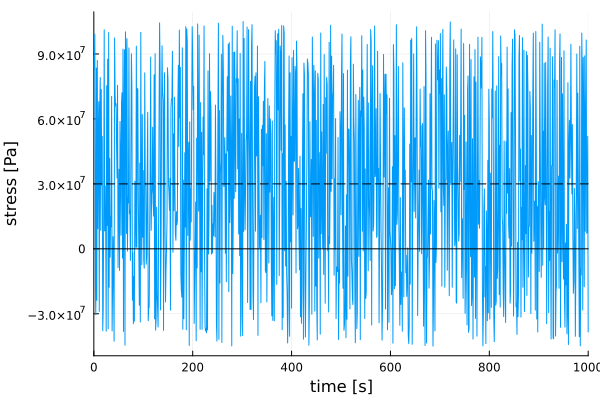

In [3]:
amplitude, mean = 150e6, 30e6
time = 1:1000
stress = (rand(length(time)) .- 0.5)*amplitude .+ mean

plot(time, stress; xlabel="time [s]", ylabel="stress [Pa]", label=nothing, xlim=(0,Inf))
hline!([mean], label=nothing, color=:black, linestyle=:dash)
hline!([0], label=nothing, color=:black, linestyle=:solid)

## Material properties

In [4]:
# Ultimate strength
ultimate_strength = 500e6

println("Ultimate strength: ", ultimate_strength, " Pa")

Ultimate strength: 5.0e8 Pa


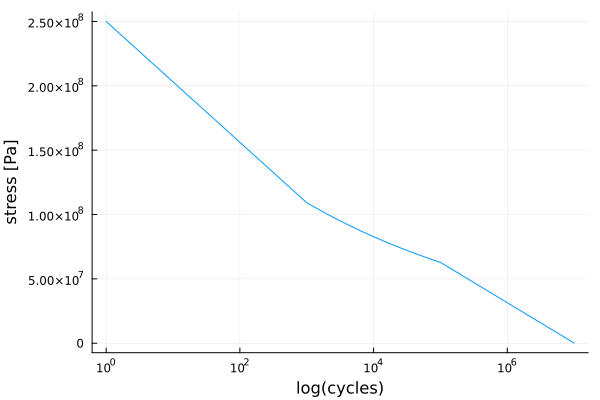

In [5]:
# S-N curve
failure_strength_coefficient = 250e6
fatigue_exponent = -0.12
ncycles = 1:1000:(1e5+1)
sn_log_cycles = log10.(ncycles)
sn_stress = failure_strength_coefficient * ncycles.^fatigue_exponent
ncycles = vcat(ncycles, 1e7)
sn_log_cycles = vcat(sn_log_cycles, log10(1e7))
sn_stress = vcat(sn_stress, 1e5)

plot(ncycles, sn_stress; xscale=:log10, xlabel="log(cycles)", ylabel="stress [Pa]", label=nothing)

## Fatigue damage

In [6]:
damage = fatigue_damage(stress, sn_stress, sn_log_cycles, ultimate_strength; nbins_amplitude=20, nbins_mean=1, mean_correction=true, wohler_exp=3, equiv_cycles=1)

println("Damage: ", damage)

Damage: 0.9263037044237644


# DEBUG: Intermediate steps

In [7]:
nbins_amplitude=20
nbins_mean=1
mean_correction=true
wohler_exp=3
equiv_cycles=1

1

In [8]:
ncycles, mean_bins, amplitude_bins, _ = rainflow(stress; nbins_range=nbins_amplitude, nbins_mean, m=wohler_exp, Teq=equiv_cycles)
# println("ncycles: ", ncycles)
size(ncycles), size(mean_bins), size(amplitude_bins)

((20, 1), (2,), (21,))

In [9]:
amplitude_levels = (amplitude_bins[1:end-1] .+ amplitude_bins[2:end]) ./ 2 # bin centers
mean_levels = (mean_bins[1:end-1] .+ mean_bins[2:end]) ./ 2 # bin centers
size(ncycles), size(mean_levels), size(amplitude_levels)
println("Mean levels: ", mean_levels)
println("correct (long term mean): ", mean)

Mean levels: [2.7871488082038093e7]
correct (long term mean): 3.0e7


Max Amplitude: 1.5e8


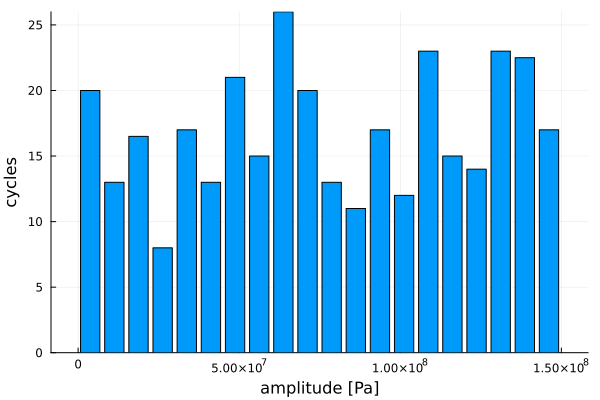

In [10]:
println("Max Amplitude: ", amplitude)
bar(amplitude_levels, ncycles; xlabel="amplitude [Pa]", ylabel="cycles", label=nothing, legend=false)

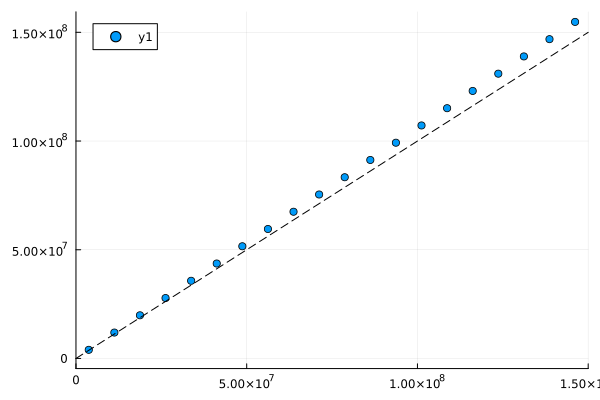

In [11]:
ncycles = [(ncycles...)] # flatten matrix
effective_amplitude_levels = [iamplitude / (1 - imean / ultimate_strength) for iamplitude in amplitude_levels, imean in mean_levels]
effective_amplitude_levels = [(effective_amplitude_levels...)] # flatten matrix
scatter(amplitude_levels, effective_amplitude_levels)
plot!([0, 1.5e8], [0, 1.5e8], label=nothing, color=:black, linestyle=:dash, xlimits=(0, 1.5e8))


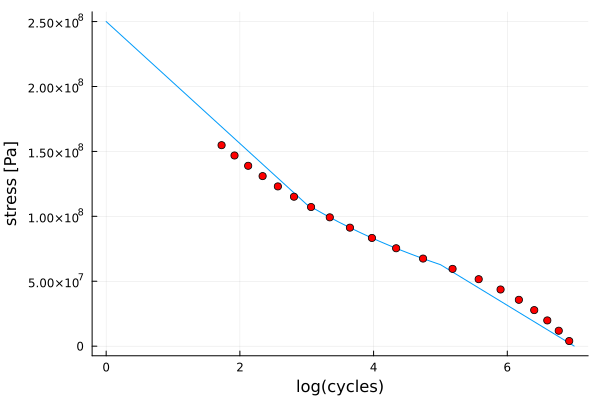

In [12]:
log_ncycles_fail = safeakima(reverse(sn_stress), reverse(sn_log_cycles), effective_amplitude_levels) # interpolation

using Interpolations
int_f = linear_interpolation(reverse(sn_stress), reverse(sn_log_cycles))
# log_ncycles_fail = int_f.(effective_amplitude_levels)

plot(sn_log_cycles, sn_stress; xlabel="log(cycles)", ylabel="stress [Pa]", label=nothing)
scatter!(log_ncycles_fail, effective_amplitude_levels; label=nothing, color=:red)

In [13]:
ncycles_fail = 10.0 .^ log_ncycles_fail

20-element Vector{Float64}:
      8.43508364929997e6
      5.882570511834504e6
      3.9663693766191215e6
      2.528197060798203e6
      1.4895803094763837e6
 793223.6285415961
 373292.7585052355
 151799.09234141937
  54966.13633821891
  21754.851585040426
   9448.060212849941
   4427.051535975982
   2211.7293480832377
   1161.115345708123
    644.9929692679741
    370.11278885529515
    218.82783754091045
    133.0945787068435
     83.13950578964388
     53.252958689593754

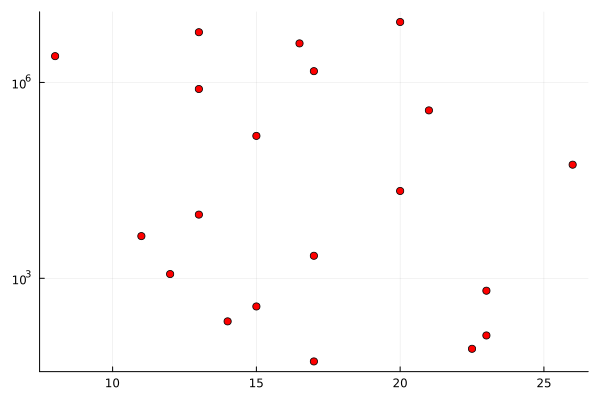

In [14]:
scatter(ncycles, ncycles_fail; yscale=:log10, label=nothing, color=:red)

In [15]:
ncycles ./ ncycles_fail

20-element Vector{Float64}:
 2.371049396962389e-6
 2.209918261727031e-6
 4.159975643535341e-6
 3.164310300034222e-6
 1.1412610580208213e-5
 1.638882092292374e-5
 5.6256114059350206e-5
 9.881482009301285e-5
 0.00047301851161624667
 0.0009193351617141283
 0.0013759438135585971
 0.0024847237287864447
 0.007686293087683986
 0.010334890538098631
 0.03565930342791726
 0.040528186141291715
 0.06397723505987972
 0.1728094429049602
 0.2706294653341886
 0.3192310890948111

In [16]:
sum(ncycles ./ ncycles_fail)

0.9263037044237644